In [1]:
import glob
import os
import cv2
import glob
import re
import json
import h5py

import matplotlib as mpl
import tifffile as tf
import pandas as pd
import pylab as pl
import seaborn as sns
import numpy as np

In [5]:
cd ../utils/

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils


In [10]:
import plotting as pplot
import rf_utils as rfutils
import gratings_utils as gutils

In [11]:
import py3utils as p3

In [12]:
%matplotlib notebook

In [13]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)

In [14]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

response_type='dff'
traceid = 'traces001'

# fit_thr=0.5
# do_spherical_correction=True

In [15]:
sdata, cells0 = p3.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
all_cell_counts = cells0[['visual_area', 'datakey', 'cell']]\
                .drop_duplicates().groupby(['visual_area']).count().reset_index()

print(all_cell_counts.groupby(['visual_area']).sum())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
             datakey  cell
visual_area               
Li              3754  3754
Lm              4461  4461
V1              4007  4007


In [18]:
# Save counts
statdir = os.path.join(aggregate_dir, 'data-stats','counts')
if not os.path.exists(statdir):
    os.makedirs(statdir)
counts_outfile = os.path.join(statdir, 'all_assigned_cells.csv')
all_cell_counts.to_csv (r'%s' % counts_outfile, index=False, header=True)
print(counts_outfile)

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/counts/all_assigned_cells.csv


# Gratings

In [16]:
def select_assigned_cells(cells0, sdata, experiments=[]):
    '''
    Return assigned cells for a specified experiment.
    cells0: master df of all assigned cells
    sdata: metadata df with all datakeys, experiments, visual areas
    '''
    if not isinstance(experiments, list):
        experiments = [experiments]
    meta_ = sdata[sdata.experiment.isin(experiments)].copy()
    dkeys_ = [(va, dk) for (va, dk), g in meta_.groupby(['visual_area', 'datakey'])]
    cells_ = pd.concat([g for (va, dk), g in \
                            cells0.groupby(['visual_area', 'datakey'])\
                            if (va, dk) in dkeys_])
    return cells_, meta_

def drop_repeats(counts, criterion='max', colname='cell'):
    '''
    From df of counts (N cells per datakey), drop repeats by criterion.
    criterion: takes "max" (or whatever func) along column <colname>
    '''
    counts = p3.split_datakey(counts)
    unique_dsets = p3.select_best_fovs(counts, criterion='max', colname='cell')
    u_dkeys = list([tuple(k) for k in unique_dsets[['visual_area', 'datakey']].values])
    return u_dkeys
    

In [17]:
def count_n_total(assigned_cells, u_dkeys):
    '''
    Count N cells total per FOV.
    assigned_cells: dataframe of assigned cells for selected experiment.
    u_dkeys:  dataframe of unique datakeys -- used to select and aggregate data.
    '''
    # N cells total per FOV
    n_total0 = pd.concat([g for (va, dk), g \
                          in assigned_cells.groupby(['visual_area', 'datakey'])\
                          if (va, dk) in u_dkeys])
    n_total = n_total0[['visual_area', 'datakey']]\
                .value_counts().reset_index()\
                .rename(columns={0:'total'})
    return n_total

def count_n_responsive(experiment, u_dkeys=None, traceid='traces001',
                      response_type='dff', trial_epoch='plushalf',
                      responsive_test='nstds', responsive_thr=10,n_stds=2.5):
    '''
    Count N responsive cells per FOV.
    Load aggregate data for each FOV, with correctly assigned cells (NDATA).
    Only include RESPONSIVE cells (specified by args)
    
    u_dkeys:  dataframe of unique datakeys -- used to select and aggregate data.
    '''
    if experiment=='gratings':
        NDATA = p3.get_aggregate_data(experiment, traceid=traceid, 
                              response_type=response_type, epoch=trial_epoch,
                              responsive_test=responsive_test, 
                              responsive_thr=responsive_thr, n_stds=n_stds)
    elif experiment=='blobs':
        NDATA = p3.get_aggregate_data(experiment, traceid=traceid, 
                              response_type=response_type, epoch=trial_epoch,
                              responsive_test=responsive_test, 
                              responsive_thr=responsive_thr, n_stds=n_stds)
    elif experiment in ['rfs', 'rfs10']:
        nd_=[]
        for exp in ['rfs', 'rfs10']:
            nd0 = p3.get_aggregate_data(exp, traceid=traceid, 
                              response_type=response_type, epoch=trial_epoch,
                              responsive_test=responsive_test, 
                              responsive_thr=responsive_thr, n_stds=n_stds)
            nd_.append(nd0)
        NDATA = pd.concat(nd_, axis=0).reset_index(drop=True)
    else:
        print("Unknown experiment type: %s" % experiment)
        return None
    
    # Get UNIQUE datasets (drop repeat FOVs)
    if u_dkeys is None:
        counts = NDATA[['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates()\
                    .groupby(['visual_area', 'datakey']).count().reset_index()
        u_dkeys = drop_repeats(counts)

    # N cells per FOV that are responsive
    NDATA1 = pd.concat([g for (va, dk), g in NDATA.groupby(['visual_area', 'datakey'])\
              if (va, dk) in u_dkeys])

    n_responsive = NDATA1[['visual_area', 'datakey','cell']]\
                        .drop_duplicates()\
                        .groupby(['visual_area', 'datakey']).count().reset_index()\
                        .rename(columns={'cell': 'responsive'})

    return n_responsive, u_dkeys


# Retino

In [179]:
# def get_retino_data(animalid, session, fov, run='retino', 
#                     rootdir='/n/coxfs01/2p-data'):
#     '''
#     Load raw traces + experiment info for dataset.
#     '''
#     expdata = retutils.get_protocol_info(animalid, session, fov, run=run)
#     # Get raw traces
#     fpath = get_traces_fpath(animalid, session, fov, retinorun=run, traceid=traceid)
#     traces = format_retino_traces(fpath, expdata=expdata, return_labels=False)
    
#     return traces, expdata

# def get_retino_stats(traces, expdata, responsive_thr=0.01):
#     '''
#     traces: dataframe of raw traces (columns=rois)
#     expdata: dict of protocol and stimulus info
#     '''
#     magratios, phases, tracedict, trialconds = do_analysis_on_raw(traces, expdata)
#     responsive_cells = [r for r in magratios.index.tolist() if \
#                                 any(magratios.loc[r] > responsive_thr)]
#     nrois_total = len(magratios.index.tolist())
#     rstats = {'magratios': magratios, 'phases': phases, 'traces': tracedict}

#     return responsive_cells, rstats

# def do_analysis_on_raw(traces, expdata):
#     '''
#     traces: dataframe of raw traces (saved to ./traces/extracted_traces.h5)
#     expdata: dict of protocol and stimulus info
#     '''
#     n_frames = expdata['stimulus']['n_frames']
#     n_files = expdata['ntiffs']
#     fr = expdata['stimulus']['frame_rate']
#     stimfreq = expdata['stimulus']['stim_freq']
#     # label frequency bins
#     freqs = np.fft.fftfreq(n_frames, float(1/fr))
#     sorted_freq_ixs = np.argsort(freqs)
#     freqs=freqs[sorted_freq_ixs]
#     # exclude DC offset from data
#     freqs=freqs[int(np.round(n_frames/2.))+1:]

#     # Identify freq idx:
#     stim_freq_ix=np.argmin(np.absolute(freqs-stimfreq)) # index of stim freq
#     print("Target freq: %.3f Hz" % (freqs[stim_freq_ix]))
#     trials_by_cond = expdata['trials']
#     trial_nums = np.array([v for k,v in trials_by_cond.items()])
#     trial_nums = sorted(trial_nums.flatten())

#     # For each condition, get average across reps (i.e., trials) for FFT:
#     nframes_total, nrois = traces.shape
#     magratios=[]; phases=[]; conds=[]
#     tracedict={}
#     for curr_cond in trials_by_cond.keys():
#         avg_traces = []
#         for rid in traces.columns:
#             tracemat = pd.DataFrame(np.reshape(traces[rid], \
#                             (n_frames, n_files), order='F'), columns=trial_nums)
#             avg = tracemat[trials_by_cond[curr_cond]].mean(axis=1)
#             avg_traces.append(avg)
#         avg_traces = pd.DataFrame(np.array(avg_traces).T, \
#                                   columns=traces.columns)
#         tracedict[curr_cond] = avg_traces
#         # do FFT on averaged trace
#         magratio_array, phase_array = do_fft_analysis(avg_traces,\
#                                         sorted_freq_ixs, stim_freq_ix, n_frames)
#         magratios.append(magratio_array)
#         phases.append(phase_array)
#         conds.append(curr_cond)
#     magratios = pd.DataFrame(np.array(magratios).T, columns=conds)
#     phases = pd.DataFrame(np.array(phases).T, columns=conds)

#     return magratios, phases, tracedict, trials_by_cond

# def do_fft_analysis(avg_traces, sorted_freq_ixs, stim_freq_ix, n_frames):
#     fft_results = np.fft.fft(avg_traces, axis=0) #avg_traces.apply(np.fft.fft, axis=1)
#     # get phase and magnitude
#     mag_data = abs(fft_results)
#     phase_data = np.angle(fft_results)
#     # sort mag and phase by freq idx:
#     mag_data = mag_data[sorted_freq_ixs]
#     phase_data = phase_data[sorted_freq_ixs]
#     # exclude DC offset from data
#     mag_data = mag_data[int(np.round(n_frames/2.))+1:, :]
#     phase_data = phase_data[int(np.round(n_frames/2.))+1:, :]
#     #unpack values from frequency analysis
#     mag_array = mag_data[stim_freq_ix, :]
#     phase_array = phase_data[stim_freq_ix, :]
#     #get magnitude ratio
#     tmp = np.copy(mag_data)
#     #tmp = np.delete(tmp,freq_idx,0)
#     nontarget_mag_array=np.sum(tmp,0)
#     magratio_array=mag_array/nontarget_mag_array

#     return magratio_array, phase_array

# def format_retino_traces(data_fpath, expdata=None, trace_type='corrected',
#                         return_labels=False):
#     labels_list=[]
#     traces=None
#     try:
#         f = h5py.File(data_fpath, 'r')
#         f1 = list(f.keys())[0]
#         nrois, nframes_per = f[f1][trace_type].shape
#         dtype = f[f1][trace_type].dtype
#         nfiles = len(f.keys())
#         tmat = np.empty((nframes_per*nfiles, nrois), dtype=dtype)
#         print("retino: nframes per trial (%i) for %i files" % (nframes_per, nfiles))
#         s_ix = 0
#         for tix, tfile in enumerate(sorted(f.keys(), key=p3.natural_keys)):
#             print("retino file %s: %i" % (tfile, s_ix))
#             tmat[s_ix:s_ix+nframes_per, :] = f[tfile][trace_type][:].T
#             # Update labels DF
#             if expdata is not None:
#                 trials_by_cond = expdata['trials']
#                 # Condition info:
#                 curr_cond = [cond for cond, trial_list in trials_by_cond.items() \
#                                             if int(tix+1) in trial_list][0]
#                 curr_trial = 'trial%05d' % int(tix+1)
#                 frame_tsecs = expdata['frame_tstamps_sec']
#                 if expdata['nchannels'] == 2:
#                     frame_tsecs = frame_tsecs[0::2]
#                 curr_labels = pd.DataFrame({'tsec': frame_tsecs,
#                                             'frame': [i for i in range(len(frame_tsecs))]
#                                             })
#                 curr_labels['config'] = curr_cond
#                 curr_labels['trial'] = curr_trial
#                 labels_list.append(curr_labels)
#             s_ix = s_ix + nframes_per
            
#         traces = pd.DataFrame(tmat)
#         if len(labels_list)>0:
#             labels = pd.concat(labels_list, axis=0).reset_index(drop=True)
#     except Exception as e:
#         print(e)
#     finally:
#         f.close()
#     if return_labels:
#         return traces, labels
#     else:
#         return traces

# def get_traces_fpath(animalid, session, fov, retinorun='retino',
#                             traceid='traces001'):
#     '''For ROI-based extraction, get path to raw traces (saved h5 file).
#     '''
#     data_fpath=None
#     roiid = roiutils.get_roiid_from_traceid(animalid, session, fov, traceid=traceid)
#     retinoid, RID = retutils.load_retino_analysis_info(animalid, session, fov, 
#                                   roiid=roiid, run=retinorun)
#     traces_fpaths = glob.glob(os.path.join(RID['DST'], \
#                                            'traces', 'extracted_traces.h5'))
#     assert len(traces_fpaths)==1, \
#         "Traces not extracted: %s\n --> (%s, %s, %s, %s)" \
#             % (retinoid, roiid, animalid, session, fov)
#     data_fpath = traces_fpaths[0]
    
#     return data_fpath

In [20]:
import importlib
import roi_utils as roiutils
import retino_utils as retutils
importlib.reload(retutils)

import dill as pkl

<module 'retino_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/retino_utils.py'>

In [100]:
def get_retino_fft(dk, traceid='traces001', mag_thr=0.01, delay_thr=0.5):
    '''
    Load FFT for dataset, return dataframe of phases & magratios for ALL cells.
    '''
    session, animalid, fovn = p3.split_datakey_str(dk)
    fov='FOV%i_zoom2p0x' % fovn
    # Select best retino run (if there are multiple)
    all_retinos = pd.DataFrame(retutils.get_average_mag_across_pixels(
                                        animalid, session, fov))
    retinorun = all_retinos.loc[all_retinos[1].idxmax()][0]
    try:
        # Get protocol info for selected retino run
        roiid = roiutils.get_roiid_from_traceid(animalid, session, fov, traceid=traceid)
        retinoid, RID = retutils.load_retino_analysis_info(animalid, session, fov, 
                                          roiid=roiid, run=retinorun)
        #expdata = retutils.get_protocol_info(animalid, session, fov, run=retinorun)
    except Exception as e:
        print(e)
        print("[%s] Unable to get retino data (%s)" % (dk, traceid))
        
    # Load fft results
    fft_results = retutils.load_fft_results(animalid, session, fov, retinorun=retinorun, 
                        traceid=traceid, create_new=False, use_pixels=False)
    if fft_results is None:
        return None
    fft_soma = fft_results['fft_soma']
    conds=['left', 'right', 'bottom', 'top']
    try:
        # Create dataframe of magratios -- each column is a condition
        magratios_soma, phases_soma = retutils.extract_from_fft_results(fft_soma)
        assert all([a in magratios_soma.columns for a in conds]), "Incorrect N conditions (%s)" % str(magratios_soma.columns)
        # #### Get maps
        df = retutils.get_final_maps(magratios_soma, phases_soma, 
                            trials_by_cond=None, mag_thr=mag_thr, delay_thr=delay_thr)
    except Exception as e:
        print(e)
        return None
    
    return df

In [132]:
def aggregate_retino_data(ret_cells, traceid='traces001', 
                          mag_thr=0.01, delay_thr=0.5, return_missing=False):
    '''
    Loop over all datasets (with assigned cells).
    Returns DF with phase/mag for both az and el (columns). 
    Includes all cells (assigned).
    '''
    retinodata=None
    r_=[]
    errs=[]
    for (va, dk), curr_cells in ret_cells.groupby(['visual_area', 'datakey']):
        df_ = get_retino_fft(dk, mag_thr=mag_thr, delay_thr=delay_thr)        
        if df_ is None:
            errs.append((va, dk))
            continue
        cell_ids = curr_cells['cell'].unique()
        df = df_.loc[cell_ids].copy()
        df['visual_area'] = va
        df['datakey'] = dk
        r_.append(df)
    retinodata = pd.concat(r_, axis=0)
    
    if return_missing:
        return retinodata, errs
    else:
        return retinodata
    
def get_retino_responsive(dk, curr_assigned_cells, traceid='traces001', 
                          mag_thr=0.01, delay_thr=1.0):
    '''
    Get phase/mag info from FFT analysis for dataset.
    From curr_assigned_cells (list or df), return fft data for responsive cells.
    '''
    df = get_retino_fft(dk, traceid=traceid, mag_thr=mag_thr, delay_thr=delay_thr)
    if df is None:
        return None
    n_total, n_conds = df.shape
    responsive_cells_all = np.where(df[['mag_az', 'mag_el']].mean(axis=1)>mag_thr)[0]
    responsive_cells = [k for k in responsive_cells_all \
                            if k in curr_assigned_cells['cell'].unique()]
    
    return df.loc[responsive_cells]

def aggregate_responsive_retino(ret_cells, traceid='traces001', 
                               mag_thr=0.01, delay_thr=0.5):
    '''
    Loop over all datasets (with assigned cells), and get responsive 
    Returns DF with phase/mag for both az and el (columns). 
    Only includes cells that pass
    '''
    ret_responsive=None
    ret_=[]
    errs=[]
    for (va, dk), curr_cells in ret_cells.groupby(['visual_area', 'datakey']):
        retdf = get_retino_responsive(dk, curr_assigned_cells, traceid=traceid, 
                              mag_thr=mag_thr, delay_thr=delay_thr)
        if retdf is None:
            errs.append((va, dk))
            continue
        retdf['visual_area'] = va
        retdf['datakey'] = dk
        ret_.append(retdf)
    ret_responsive = pd.concat(ret_, axis=0)
    return ret_responsive

In [91]:
importlib.reload(retutils)

<module 'retino_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/retino_utils.py'>

In [128]:
stats_dir = os.path.join(aggregate_dir, 'data-stats')
retino_dfile = os.path.join(stats_dir, 'aggr_retinodata_best.pkl')
if not os.path.exists(retino_dfile):
    create_new=True

In [133]:
# Get retino cells
ret_cells, ret_meta = select_assigned_cells(cells0, sdata, experiments=['retino']) 
create_new=True
mag_thr=0.01
delay_thr=0.5
if create_new:   
    retinodata, errs = aggregate_retino_data(ret_cells, traceid=traceid, 
                          mag_thr=mag_thr, delay_thr=delay_thr, return_missing=True)
    with open(retino_dfile, 'wb') as f:
        pkl.dump(retinodata, f, protocol=2)

list index out of range
Error loading analysis: retino_run2 (JC070, 20190314, FOV1_zoom2p0x)
list index out of range
NO retino for rois w/ traces001
---(check dir: /n/coxfs01/2p-data/JC070/20190314/FOV1_zoom2p0x/retino_run1)


Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/retino_utils.py", line 487, in load_fft_results
    assert RETID is not None
AssertionError


No analysis found for file: 1
No analysis found for file: 2
Incorrect N conditions (Index(['bottom', 'left', 'top'], dtype='object'))
list index out of range
[20190315_JC070_fov3] Unable to get retino data (traces001)


In [134]:
retinodata.head()

,phase_az,phase_el,mag_az,mag_el,visual_area,datakey
85.0,1.434389,-0.041796,0.008565,0.016800,Li,20190315_JC070_fov1
86.0,NaN,NaN,NaN,NaN,Li,20190315_JC070_fov1
99.0,NaN,NaN,0.015429,0.006508,Li,20190315_JC070_fov1
101.0,1.443087,-0.017280,0.005226,0.009383,Li,20190315_JC070_fov1
102.0,NaN,NaN,0.026345,0.017770,Li,20190315_JC070_fov1


In [136]:
p_ = []
for (va, dk), rdf in retinodata.dropna().groupby(['visual_area', 'datakey']):
    pass_ = np.where(rdf[['mag_az', 'mag_el']].mean(axis=1)>mag_thr)[0]
    df_ = rdf.loc[pass_]
    p_.append(df_)
    
retino_responsive = pd.concat(p_, axis=0)

KeyError: "None of [Int64Index([ 0,  2,  3,  4,  5,  7,  8, 14, 17, 20, 24, 25, 26, 29, 30, 31, 33,\n            34, 38, 39, 42, 43, 46, 47, 50, 51, 53, 56, 57, 59, 61, 65],\n           dtype='int64')] are in the [index]"

In [ ]:
retino_responsive.shape, retino_responsive.dropna().shape

In [112]:
retino_responsive.shape, retino_responsive.dropna().shape

((5301, 6), (2577, 6))

In [118]:
retino_counts = retino_responsive.dropna().groupby(['visual_area', 'datakey'])['mag_az'].count()\
                    .reset_index().rename(columns={'mag_az': 'cell'})
# Get unique
u_dkeys = drop_repeats(retino_counts)
n_responsive = pd.concat([g for (va, dk), g in \
                          retino_counts.groupby(['visual_area', 'datakey'])
                         if (va, dk) in u_dkeys])

,responsive
visual_area,
Li,722
Lm,886
V1,969


In [123]:
n_total = count_n_total(ret_cells, u_dkeys)
n_total.shape, n_responsive.shape

((48, 3), (48, 6))

# Receptive Fields

In [25]:
assigned_cells, rf_meta = select_assigned_cells(cells0, sdata, 
                                                experiments=['rfs', 'rfs10']) 

In [26]:
do_spherical_correction=False
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                 do_spherical_correction=do_spherical_correction)
rfdata = rfutils.aggregate_rfdata(rf_meta, assigned_cells, fit_desc=rf_fit_desc,
                                 reliable_only=False)
# Combined rfs5/rfs10
combined_rfs = rfutils.average_rfs_select(rfdata)

N dpaths: 65, N unfit: 0
N datasets included: 65, N sessions excluded: 4


In [59]:
counts = combined_rfs[['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates()\
                    .groupby(['visual_area', 'datakey']).count().reset_index()
u_dkeys = drop_repeats(counts)

[V1] Animalid does not exist: JC078 


In [68]:
u_dkeys = drop_repeats(counts)

[V1] Animalid does not exist: JC078 


In [69]:
len(u_dkeys)

32

In [96]:
trial_epoch='plushalf'
responsive_test='nstds'
responsive_thr=5
n_stds=2.5
n_responsive, _ = count_n_responsive('rfs', u_dkeys=u_dkeys, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['rfs', 'rfs10']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_rfs_trialmeans_traces001_nstds-thr-5.00_dff_plushalf.pkl
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['rfs', 'rfs10']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_rfs10_trialmeans_traces001_nstds-thr-5.00_dff_plushalf.pkl


In [97]:
n_responsive.groupby(['visual_area']).sum()

,responsive
visual_area,
Li,872
Lm,918
V1,1255


In [98]:
rfdata[['visual_area', 'datakey', 'cell']]\
.drop_duplicates().groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,450,450
Lm,422,422
V1,1090,1090


In [99]:
n_total = count_n_total(assigned_cells, u_dkeys)
n_total.groupby(['visual_area']).sum()

,total
visual_area,
Li,1708
Lm,2267
V1,2583


In [100]:
n_total.groupby(['visual_area'])['datakey'].count()

visual_area
Li    11
Lm    11
V1    10
Name: datakey, dtype: int64

In [101]:
n_responsive.groupby(['visual_area'])['datakey'].count()

visual_area
Li    11
Lm     7
V1     6
Name: datakey, dtype: int64

In [106]:
n_responsive

,visual_area,datakey,responsive
0,Li,20190522_JC089_fov1,18
1,Li,20190527_JC092_fov3,90
2,Li,20190528_JC092_fov1,41
3,Li,20190602_JC091_fov1,146
4,Li,20190609_JC099_fov1,122
5,Li,20190614_JC091_fov1,161
6,Li,20190617_JC099_fov1,45
7,Li,20191012_JC113_fov1,32
8,Li,20191017_JC113_fov1,81
9,Li,20191105_JC117_fov1,65


In [108]:
n_total[n_total.visual_area=='V1']

,visual_area,datakey,total
0,V1,20190616_JC097_fov1,429
1,V1,20190617_JC097_fov1,420
2,V1,20191006_JC110_fov1,391
3,V1,20190622_JC085_fov1,312
8,V1,20190522_JC084_fov1,260
12,V1,20190501_JC076_fov1,226
14,V1,20190613_JC097_fov1,225
19,V1,20190507_JC083_fov1,182
25,V1,20190420_JC076_fov1,96
30,V1,20190508_JC083_fov1,42


In [109]:
rfdata[(rfdata.visual_area=='V1') & (rfdata.datakey=='20190501_JC076_fov1')]

,x0,y0,fwhm_x,fwhm_y,theta,r2,cell,datakey,animalid,session,...,fx,fy,ratio_xy,theta_c,theta_Mm_deg,major_axis,minor_axis,anisotropy,theta_Mm_c,aniso_index
926,27.193921,11.135739,37.912956,24.605137,0.135210,0.511198,45.0,20190501_JC076_fov1,JC076,20190501,...,15.985926,2.174730,1.540855,0.135210,7.746976,16.133173,10.470271,0.212863,0.135210,-0.155476
927,23.568150,3.715528,27.758004,17.266723,0.152932,0.637421,79.0,20190501_JC076_fov1,JC076,20190501,...,11.674057,1.799382,1.607601,0.152932,8.762336,11.811917,7.347542,0.233012,0.152932,-0.162019
928,19.129528,4.542962,13.640834,6.767753,0.457498,0.765985,150.0,20190501_JC076_fov1,JC076,20190501,...,5.207666,2.563926,2.015563,0.457498,26.212728,5.804610,2.879895,0.336774,0.457498,-0.039264
929,33.129773,-4.333284,16.820882,12.485125,1.067717,0.655458,156.0,20190501_JC076_fov1,JC076,20190501,...,3.450969,6.270983,1.347274,1.067717,61.175684,7.157822,5.312819,0.147948,1.067717,0.111287
930,29.767298,-1.503937,34.400282,22.341540,5.649143,0.527169,161.0,20190501_JC076_fov1,JC076,20190501,...,11.793285,8.671891,1.539745,-0.634042,323.672046,14.638418,9.507038,0.212519,-0.634042,0.039276
931,34.243113,-2.930111,24.536467,9.975445,6.250170,0.720906,193.0,20190501_JC076_fov1,JC076,20190501,...,10.435360,0.344654,2.459686,-0.033016,358.108350,10.441050,4.244870,0.421913,-0.033016,-0.394059
932,36.133613,-1.679177,22.722975,15.042326,0.143470,0.581911,207.0,20190501_JC076_fov1,JC076,20190501,...,9.570007,1.382504,1.510603,0.143470,8.220203,9.669351,6.400990,0.203378,0.143470,-0.145221
933,40.233746,-5.214633,19.126985,9.823211,6.268417,0.632546,210.0,20190501_JC076_fov1,JC076,20190501,...,8.138255,0.120193,1.947122,-0.014768,359.153864,8.139143,4.180090,0.321372,-0.014768,-0.311880
934,35.506518,1.125157,27.619941,23.911364,5.801177,0.547323,225.0,20190501_JC076_fov1,JC076,20190501,...,10.414079,5.448291,1.155097,-0.482008,332.382968,11.753166,10.175049,0.071967,-0.482008,-0.005245


In [103]:
assert n_responsive.shape==n_total.shape, \
        "N responsive (%i) does not match N total (%i)" \
    % (n_responsive.shape[0], n_total.shape[0])
print(n_responsive.shape, n_total.shape)

AssertionError: N responsive (24) does not match N total (32)

In [104]:
[k for k in n_responsive['datakey'].values if k not in n_total['datakey'].values]

[]

In [105]:
[k for k in n_total['datakey'].values if k not in n_responsive['datakey'].values]

['20190430_JC078_fov1',
 '20190508_JC083_fov1',
 '20190501_JC076_fov1',
 '20190507_JC083_fov1',
 '20190504_JC078_fov1',
 '20190423_JC076_fov1',
 '20190420_JC076_fov1',
 '20190508_JC083_fov1']

In [94]:
n_total

,visual_area,datakey,total
0,Li,20190522_JC089_fov1,1
1,Li,20190527_JC092_fov3,1
2,V1,20190622_JC085_fov1,1
3,V1,20190617_JC097_fov1,1
4,V1,20190616_JC097_fov1,1
5,V1,20190613_JC097_fov1,1
6,V1,20190522_JC084_fov1,1
7,V1,20190508_JC083_fov1,1
8,V1,20190507_JC083_fov1,1
9,V1,20190501_JC076_fov1,1


In [52]:
common_ = pd.merge(n_responsive, n_total)

In [53]:
rfdf = pd.concat([g for (va, dk), g in combined_rfs.groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])

In [54]:
n_fit = rfdf[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()\
                .rename(columns={'cell': 'fit'})

In [55]:
common = pd.merge(common_, n_fit)


In [56]:
common['fraction_fit'] = common['fit'] / common['responsive']


In [58]:
common.groupby(['visual_area']).describe()

responsive                                                    \
                 count        mean        std   min    25%    50%    75%   
visual_area                                                                
Li                11.0   48.272727  36.072402  11.0  25.00   37.0   63.0   
Lm                 9.0   76.888889  47.395792   7.0  38.00   83.0  113.0   
V1                 8.0  121.625000  55.938582  42.0  88.75  120.5  151.5   

                   total              ...    fit        fraction_fit  \
               max count        mean  ...    75%    max        count   
visual_area                           ...                              
Li           117.0  11.0  162.818182  ...  40.00   75.0         11.0   
Lm           141.0   9.0  215.666667  ...  40.00   59.0          9.0   
V1           219.0   8.0  287.125000  ...  91.75  134.0          8.0   

                                                                         \
                 mean       std       min       25%       50%       75%   
visual_area                                                               
Li           0.488444  0.251267  0.058824  0.333333  0.454545  0.671906   
Lm           0.347108  0.169249  0.070796  0.259740  0.373494  0.428571   
V1           0.511018  0.237170  0.190476  0.363226  0.487736  0.682984   

                       
                  max  
visual_area            
Li           0.810811  
Lm           0.631579  
V1           0.887417  

[3 rows x 32 columns]

In [ ]:
experiment='gratings'

In [21]:
import importlib

In [59]:
importlib.reload(rfutils)

<module 'utils.rf_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/rf_utils.py'>

In [147]:
animalid = 'JC084'
session = '20190525'
fovnum = 1
run='rfs'
dk = '%s_%s_fov%i' % (session, animalid, fovnum)
responsive_cells, ncells_total = p3.get_responsive_cells(animalid, session, fovnum, 
                                        run=run,
                                        responsive_test='nstds', responsive_thr=5,
                                        create_new=False)

list index out of range


Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/py3utils.py", line 1432, in get_responsive_cells
    #response_type=response_type,
IndexError: list index out of range


In [145]:
len(responsive_cells), ncells_total

(189, 260)

In [70]:
importlib.reload(rfutils)

<module 'utils.rf_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/rf_utils.py'>

In [28]:
# responsive_test='nstds'
# responsive_thr=10
# n_stds = 2.5

In [211]:
c_=[]
for experiment in ['rfs', 'gratings', 'blobs']:
    if experiment=='gratings':
        assigned_cells, _ = select_assigned_cells(cells0, sdata, 
                                                      experiments=[experiment])
        # Drop repeat FOVs by selecting those with most gratings fits
        fit_thr=0.5; n_bootstrap_iters=1000; n_resamples=20;
        ori_fit_desc = gutils.get_fit_desc(response_type=response_type, 
                                        responsive_test=responsive_test, 
                                        n_stds=n_stds, responsive_thr=responsive_thr, 
                                        n_bootstrap_iters=n_bootstrap_iters, 
                                        n_resamples=n_resamples)
        gdata, missing_ = gutils.aggregate_ori_fits(assigned_cells, 
                                        traceid=traceid, fit_desc=ori_fit_desc, 
                                        return_missing=True) 
        print("Missing %i datasets" % len(missing_))
        counts = gdata[gdata['gof']>=fit_thr][['visual_area', 'datakey', 'cell']]\
                            .drop_duplicates()\
                            .groupby(['visual_area', 'datakey']).count().reset_index()
        u_dkeys = drop_repeats(counts)
        n_responsive, _ = count_n_responsive(experiment, u_dkeys=u_dkeys, 
                                                traceid=traceid)
    elif experiment=='blobs':
        assigned_cells, _ = select_assigned_cells(cells0, sdata, 
                                                experiments=[experiment])
        n_responsive, u_dkeys = count_n_responsive(experiment, 
                                                u_dkeys=None, traceid=traceid)
    elif experiment in ['rfs', 'rfs10']:
        assigned_cells, rf_meta = select_assigned_cells(cells0, sdata, 
                                                  experiments=['rfs', 'rfs10']) 
        # Drop repeat FOVs by selecting those with most RF fits
#         do_spherical_correction=False
#         rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
#                                        do_spherical_correction=do_spherical_correction)
#         rfdata = rfutils.aggregate_rfdata(rf_meta, assigned_cells, 
#                                     fit_desc=rf_fit_desc, reliable_only=False)
#         # Combined rfs5/rfs10
#         combined_rfs = rfutils.average_rfs_select(rfdata)
#         counts = combined_rfs[['visual_area', 'datakey', 'cell']].drop_duplicates()\
#                     .groupby(['visual_area', 'datakey']).count().reset_index()
#         u_dkeys = drop_repeats(counts)
        n_responsive, _ = count_n_responsive(experiment, 
                                             u_dkeys=None, traceid=traceid)

    # N cells total per FOV
    n_total = count_n_total(assigned_cells, u_dkeys)
    assert n_responsive.shape==n_total.shape, \
        "N responsive (%i) does not match N total (%i)" \
        % (n_responsive.shape[0], n_total.shape[0])

    counts = pd.merge(n_responsive, n_total)
    counts['fraction_responsive'] = counts['responsive']/counts['total'].astype(float)
    counts['stimulus'] = experiment
    c_.append(counts)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['rfs', 'rfs10']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_rfs_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['rfs', 'rfs10']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_rfs10_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/gratings_utils.py:174: RuntimeWarning: invalid value encountered in sqrt
  gfit = np.mean(bootr['results']['r2']) * (1-iqr) * np.sqrt(r2_comb)


Missing 1 datasets
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['gratings']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['blobs']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [0.0 -15.0], y: [0.0 -5.0]
[V1] Animalid does not exist: JC078 


In [213]:
len(c_)

3

In [214]:
COUNTS = pd.concat(c_, axis=0)
COUNTS.head()

,visual_area,datakey,responsive,total,fraction_responsive,stimulus
0,Li,20190522_JC089_fov1,4,32,0.125000,rfs
1,Li,20190527_JC092_fov3,41,118,0.347458,rfs
2,Li,20190528_JC092_fov1,31,47,0.659574,rfs
3,Li,20190602_JC091_fov1,67,197,0.340102,rfs
4,Li,20190607_JC091_fov1,67,280,0.239286,rfs


In [215]:
# N cells per FOV that pass
# fits_drop = pd.concat([g for (va, dk), g in \
#                         fits_.groupby(['visual_area', 'datakey']) 
#                         if (va, dk) in u_dkeys])
# gratings_pass = fits_drop[['visual_area', 'datakey','cell']]\
#                         .drop_duplicates()\
#                         .groupby(['visual_area', 'datakey']).count().reset_index()\
#                         .rename(columns={'cell': 'good_fit'})

In [128]:
# assert ncells.shape==gratings_pass.shape
# counts = pd.merge(counts_df, gratings_pass)
# counts['fraction_goodfit'] = counts['good_fit']/counts['responsive'].astype(float)
# counts.head()

In [100]:
%matplotlib notebook

<IPython.core.display.Javascript object>


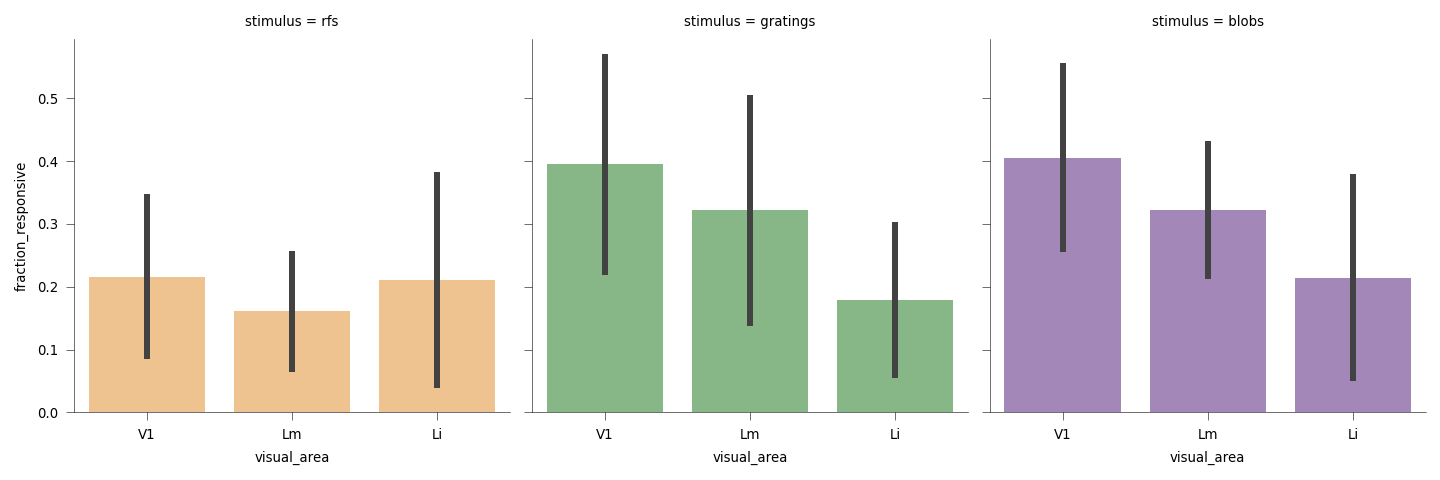

In [232]:
e_colors = {'retino': 'dark pink', 'rfs': 'darkorange', 
            'gratings': 'green', 'blobs': 'indigo'}

g = sns.FacetGrid(col='stimulus', data=COUNTS, 
                  col_order=['rfs', 'gratings', 'blobs'],
                  hue='stimulus', palette=e_colors) #'colorblind')
g.map(sns.barplot, 'visual_area', 'fraction_responsive', 
     order=visual_areas, ci='sd', alpha=0.5)
# sns.barplot(x='visual_area', y='fraction_responsive', data=counts, ax=ax,
#            order=visual_areas, color='gray', ci='sd')
# ax=axn[1]
# sns.barplot(x='visual_area', y='fraction_goodfit', data=counts, ax=ax,
#            order=visual_areas, color='gray', ci='sd')

# Select example cells spanning ALL stimuli

In [106]:
experiment='gratings'

fit_thr=0.5; n_bootstrap_iters=1000; n_resamples=20;
assigned_cells, _ = select_assigned_cells(cells0, sdata, 
                                                      experiments=[experiment])
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, 
                                responsive_test=responsive_test, 
                                n_stds=n_stds, responsive_thr=responsive_thr, 
                                n_bootstrap_iters=n_bootstrap_iters, 
                                n_resamples=n_resamples)
gdata, missing_ = gutils.aggregate_ori_fits(assigned_cells, 
                                traceid=traceid, fit_desc=ori_fit_desc, 
                                return_missing=True) 

In [107]:
gof_thr=0.5
gratings_ = gdata[gdata['gof']>=gof_thr][['visual_area', 'datakey', 'cell']]\
            .drop_duplicates()
gratings_.groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,98,98
Lm,293,293
V1,341,341


In [109]:
rf_cells, rf_meta = select_assigned_cells(cells0, sdata, 
                                          experiments=['rfs', 'rfs10']) 
# Drop repeat FOVs by selecting those with most RF fits
do_spherical_correction=False
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                               do_spherical_correction=do_spherical_correction)
rfdata = rfutils.aggregate_rfdata(rf_meta, rf_cells, 
                            fit_desc=rf_fit_desc, reliable_only=False)
# Combined rfs5/rfs10
rfdata_avg = rfutils.average_rfs_select(rfdata)

# Get RF cells
rfs_ = rfdata_avg[['visual_area', 'datakey', 'cell']]\
            .drop_duplicates()
rfs_.groupby(['visual_area']).count()

N dpaths: 65, N unfit: 0
N datasets included: 65, N sessions excluded: 4


In [120]:
# Get blobs
trial_epoch='plushalf'
responsive_test='ROC'
responsive_thr=0.05
NDATA = p3.get_aggregate_data('blobs', traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr, n_stds=n_stds)
objects_ = NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['blobs']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [0.0 -15.0], y: [0.0 -5.0]


In [121]:
f_=[]
for (va, dk), curr_rfs in rfs_.groupby(['visual_area', 'datakey']):
    cells_1 = curr_rfs['cell'].unique()
    # Get grartings cells
    curr_grat = gratings_[(gratings_.visual_area==va) & (gratings_.datakey==dk)].copy()
    cells_2 = curr_grat['cell'].unique()
    # Get cells in both
    common_ = np.intersect1d(cells_1, cells_2)
    
    # Get blobs
    curr_obj = objects_[(objects_.visual_area==va) & (objects_.datakey==dk)].copy()
    cells_3 = curr_obj['cell'].unique()
    common_1 = np.intersect1d(common_, cells_3)
    
    final_cells = curr_rfs[curr_rfs['cell'].isin(common_1)]
    f_.append(final_cells)
ccounts = pd.concat(f_)
ccounts.shape

(188, 3)

In [122]:
ccounts.groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,24,24
Lm,43,43
V1,121,121


In [124]:
ccounts[ccounts['visual_area']=='Li']

,visual_area,datakey,cell
52,Li,20190602_JC091_fov1,16.0
54,Li,20190602_JC091_fov1,23.0
57,Li,20190602_JC091_fov1,26.0
62,Li,20190602_JC091_fov1,34.0
68,Li,20190602_JC091_fov1,42.0
69,Li,20190602_JC091_fov1,43.0
75,Li,20190602_JC091_fov1,51.0
81,Li,20190602_JC091_fov1,64.0
89,Li,20190602_JC091_fov1,74.0
90,Li,20190602_JC091_fov1,76.0


In [125]:
va='Li'
dk='20190602_JC091_fov1'
rid=16

bdata = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)
            & (NDATA['cell']==rid)].copy()

bdata.shape

(1499, 6)

In [145]:
np.reshape(bdata.groupby(['config'])['response'].mean().index.tolist(), (10, 5)).T


array([['config001', 'config006', 'config011', 'config016', 'config021',
        'config026', 'config031', 'config036', 'config041', 'config046'],
       ['config002', 'config007', 'config012', 'config017', 'config022',
        'config027', 'config032', 'config037', 'config042', 'config047'],
       ['config003', 'config008', 'config013', 'config018', 'config023',
        'config028', 'config033', 'config038', 'config043', 'config048'],
       ['config004', 'config009', 'config014', 'config019', 'config024',
        'config029', 'config034', 'config039', 'config044', 'config049'],
       ['config005', 'config010', 'config015', 'config020', 'config025',
        'config030', 'config035', 'config040', 'config045', 'config050']],
      dtype='<U9')

<IPython.core.display.Javascript object>


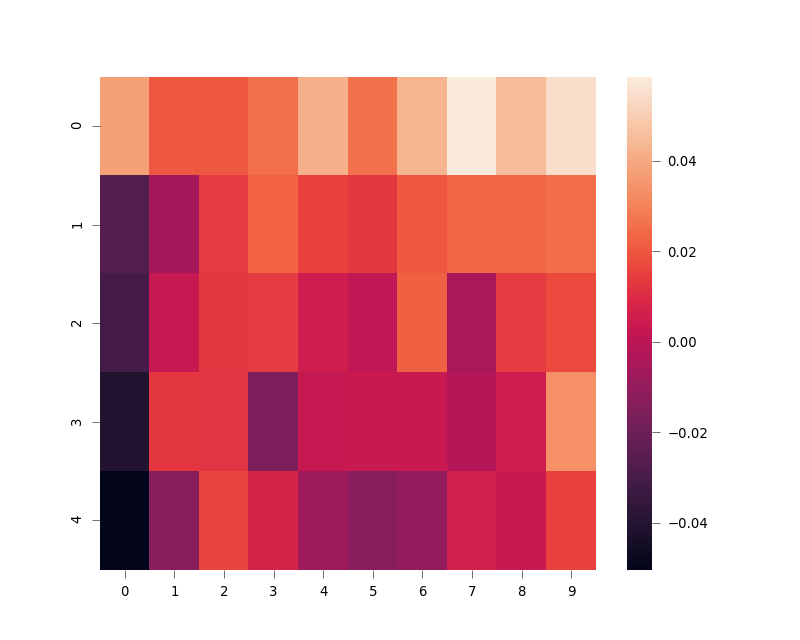

<AxesSubplot:>

In [143]:
obj_map = np.reshape(bdata.groupby(['config'])['response'].mean().values, (10, 5)).T
pl.figure()
sns.heatmap(obj_map)


In [139]:
sdf = p3.get_stimuli(dk, 'blobs')


In [141]:
sdf.loc[bdata.groupby(['config']).mean().index.tolist()]

,xpos,color,object,ypos,morphlevel,stimtype,yrot,size
config001,20.0,0.08,control,-8.0,-1,image,0,30.0
config002,20.0,0.2,control,-8.0,-1,image,0,40.0
config003,20.0,0.32,control,-8.0,-1,image,0,50.0
config004,20.0,0.44,control,-8.0,-1,image,0,10.0
config005,20.0,0.56,control,-8.0,-1,image,0,20.0
config006,20.0,,Blob_N1,-8.0,0,image,0,10.0
config007,20.0,,Blob_N1,-8.0,0,image,0,20.0
config008,20.0,,Blob_N1,-8.0,0,image,0,30.0
config009,20.0,,Blob_N1,-8.0,0,image,0,40.0
config010,20.0,,Blob_N1,-8.0,0,image,0,50.0
